In [1]:
from utils import encode_prompt, latent_to_PIL, PIL_to_latent

# Text Encoder

In [2]:
import torch
from transformers import Gemma2Model, GemmaTokenizerFast

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [3]:
model_repo = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

tokenizer = GemmaTokenizerFast.from_pretrained(
    model_repo, 
    subfolder="tokenizer", 
    torch_dtype=dtype
)

text_encoder = Gemma2Model.from_pretrained(
    model_repo, 
    subfolder="text_encoder", 
    torch_dtype=dtype
).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
prompt = "A beautiful mountain landscape"

# lower case prompt. see https://github.com/huggingface/diffusers/blob/e8aacda762e311505ba05ae340af23b149e37af3/src/diffusers/pipelines/sana/pipeline_sana.py#L433
prompt = prompt.lower().strip()

# text string to token ids
prompt_tok = tokenizer(
    prompt, 
    return_tensors="pt", 
    return_attention_mask=True, 
    # padding="max_length", 
    truncation=True, 
    max_length=300, 
    add_special_tokens=True
).to(text_encoder.device)

# encode token ids
with torch.no_grad():
    prompt_encoded=text_encoder(**prompt_tok)
    
print("prompt_encoded['input_ids']:\n", prompt_tok["input_ids"])
print("prompt_encoded['attention_mask']:\n", prompt_tok["attention_mask"])
print("prompt_encoded.last_hidden_state.shape:\n", prompt_encoded.last_hidden_state.shape)


prompt_encoded['input_ids']:
 tensor([[     2, 235250,   4964,   8180,  15487]], device='cuda:0')
prompt_encoded['attention_mask']:
 tensor([[1, 1, 1, 1, 1]], device='cuda:0')
prompt_encoded.last_hidden_state.shape:
 torch.Size([1, 5, 2304])


# Generating Random Noise

In [5]:
from diffusers import AutoencoderDC, SanaTransformer2DModel

model_repo = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

transformer = SanaTransformer2DModel.from_pretrained(
    model_repo,
    subfolder="transformer", 
    torch_dtype=dtype
).to(device)

dcae = AutoencoderDC.from_pretrained(
    model_repo, 
    subfolder="vae", 
    torch_dtype=dtype
).to(device)

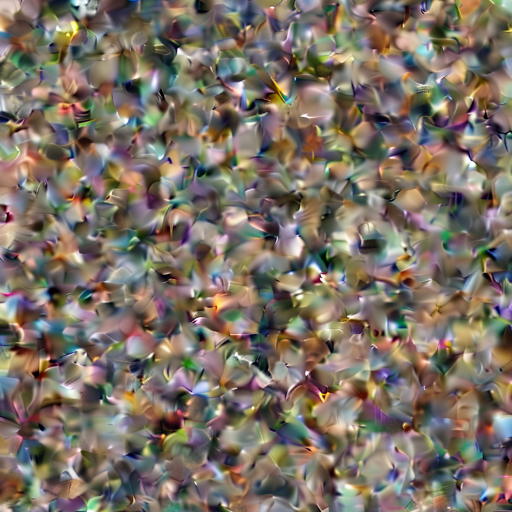

In [6]:
# batch size 1, 32 channels, height/width of 16 (=1024/32)
latent = torch.randn(
    [1, 32, 32, 32],
    dtype=dtype,
    generator=torch.manual_seed(42)
).to(device)

# fixed constant scaling_factor applied before invoking AutoEncoder
latent_to_PIL(latent / dcae.config["scaling_factor"], dcae).resize((512, 512))

sigmas tensor([1.0000, 0.9500, 0.9000, 0.8500, 0.8000, 0.7500, 0.7000, 0.6500, 0.6000,
        0.5500, 0.5000, 0.4500, 0.4000, 0.3500, 0.3000, 0.2500, 0.2000, 0.1500,
        0.1000, 0.0500, 0.0000])
timesteps tensor([1000.,  950.,  900.,  850.,  800.,  750.,  700.,  650.,  600.,  550.,
         500.,  450.,  400.,  350.,  300.,  250.,  200.,  150.,  100.,   50.,
           0.])


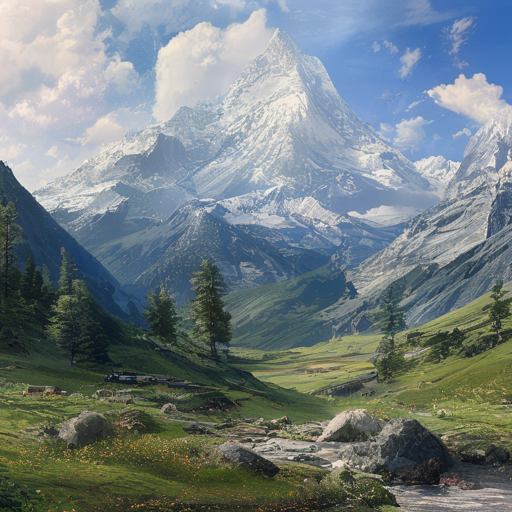

In [7]:
prompt = prompt = "A beautiful mountain landscape, photorealistic"

# Encode the prompt
prompt_encoded, prompt_atnmask = encode_prompt(prompt, tokenizer, text_encoder)

# Number of steps to take from noise to image
num_steps = 20

# Divide 1000 -> 0 in equally sized steps
timesteps = torch.linspace(1000, 0, num_steps + 1)

# Noise level. 1.0 -> 0.0 in equally sized steps
sigmas = timesteps / 1000

print("sigmas", sigmas)
print("timesteps", timesteps)

latent = torch.randn(
    [1, 32, 32, 32], 
    generator = torch.manual_seed(32)
).to(dtype).to(device)

for t, sigma_prev, sigma_next, steps_left in zip(
    timesteps, 
    sigmas[:-1], 
    sigmas[1:], 
    range(num_steps, 0, -1)
):
    # DiT predicts noise
    with torch.no_grad():
        noise_pred = transformer(
            latent, 
            timestep=t[None].to(dcae.dtype).to(dcae.device), 
            encoder_hidden_states=prompt_encoded, 
            encoder_attention_mask=prompt_atnmask, 
            return_dict=False
        )[0]
    # Remove noise from latent
    latent = latent + (sigma_next - sigma_prev) * noise_pred 

latent_to_PIL(latent / dcae.config["scaling_factor"], dcae).resize((512, 512))